# Fit beta distributions to the simulations
This will require monitoring and quality control and thus an interactive approach

In [1]:
import sqlite3 
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.utils import *
from src.approximation import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

In [2]:
database = './simulations_nu0.2.db'
con=sqlite3.connect(database) 
cur = con.cursor()
simulations = pd.read_sql_query(f"SELECT * from simulations", con)
con.close()
print("system parameters that were simulated:")
print(f"N = {simulations['N'].unique()}")
print(f"K = {simulations['K'].unique()}")
print(f"mu = {simulations['mu'].unique()}")
print(f"seed = {simulations['seed'].unique()}")
# delete dataframe
del simulations

system parameters that were simulated:
N = [10000]
K = [100]
mu = [0.2]
seed = [1000]


In [3]:
# specify system parameters
params = {
    'N': 10000, # number of nodes
    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'seed': 1000 # random seed 
}

con=sqlite3.connect(database) 
cur = con.cursor()
# load table from database into pandas dataframe
simulations = pd.read_sql_query(f"SELECT * from simulations WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND seed={params['seed']}", con)
beta_approximations = pd.read_sql_query(f"SELECT * from beta_approximations ", con)
beta_approximations = beta_approximations[beta_approximations['simulation_id'].isin(simulations['simulation_id'])]
con.close()
print(f'For specified parameters we have {len(simulations)} simulations and {len(beta_approximations)} beta approximations')
selection = simulations[~simulations['simulation_id'].isin(beta_approximations['simulation_id'])]
print(f'There are {len(selection)} simulations without beta approximation:')
selection

For specified parameters we have 2975 simulations and 2975 beta approximations
There are 0 simulations without beta approximation:


,simulation_id,N,K,lambda,mu,h,window,seed,raw_file,dataset


## Fit the data with a beta distribution
We are fitting the samples from the activity traces with a beta distribution. Since we are considering mean activity, this matches the support of the beta distribution [0,1] for infinitely large system sizes. For small system sizes, we extend the support for [-1/N, 1+1/N] by setting the `loc` and `scale` parameters of the distribution accordingly. 

Notice: For $\lambda\to 1$ and $h\to 0$ the probability distribution of activity becomes a power law, which cannot be captured by the beta distribution. For the subsequent analysis this is not relevant because we are further convolving the distribution with a Gaussian and consider sufficienty large overlaps such that the tails are less relevant.

In [4]:
con=sqlite3.connect(database) 
cur = con.cursor()

# check that table exists
table='beta_approximations'
cur.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table}'")
if len(cur.fetchall())==0:
    # throw error
    raise ValueError(f'Table {table} does not exist in database')

for i, sim in tqdm(selection.iterrows(), total=len(selection)):
    # simulation_id
    simulation_id = sim['simulation_id']
    # discretization from system size
    delta = 1/sim['N']
    # raw_file 
    raw_file = sim['raw_file']
    # dataset in raw_file
    dataset = sim['dataset']
    # load data from dataset in raw_file (hdf5)
    with h5py.File(raw_file, 'r') as file:
        data = np.array(file[dataset])
        # fit beta distribution
        a,b,loc,scale = fit_beta_distribution(data, delta)
        # add result to database
        params_db={'simulation_id':simulation_id, 'a':a, 'b':b, 'loc':loc, 'scale':scale}
        insert_into_database(con, cur, table, params_db)         
con.commit()
con.close()


  0%|          | 0/2975 [00:00<?, ?it/s]

100%|██████████| 2975/2975 [12:53<00:00,  3.85it/s]


## Quality control of beta approximation

In [4]:
con=sqlite3.connect(database) 
cur = con.cursor()
beta_approximations = pd.read_sql_query("SELECT * from beta_approximations", con)
con.close()
beta_approximations = beta_approximations[beta_approximations['simulation_id'].isin(simulations['simulation_id'])]
df = pd.merge(simulations, beta_approximations, on='simulation_id')
# drop N,K, mu, raw_file, dataset
df

,simulation_id,N,K,lambda,mu,h,window,seed,raw_file,dataset,a,b,loc,scale
0,296,10000,100,0.0000,0.2,3.162278e-07,1.0,1000,/scratch02.local/johannes/projects/sahel_finit...,samples/1.0,42.406648,422888.514316,-0.0001,1.0002
1,297,10000,100,0.0000,0.2,3.162278e-07,10.0,1000,/scratch02.local/johannes/projects/sahel_finit...,samples/10.0,46.393887,462650.237892,-0.0001,1.0002
2,298,10000,100,0.0000,0.2,3.162278e-07,100.0,1000,/scratch02.local/johannes/projects/sahel_finit...,samples/100.0,47.639217,475068.976968,-0.0001,1.0002
3,299,10000,100,0.0000,0.2,3.162278e-07,1000.0,1000,/scratch02.local/johannes/projects/sahel_finit...,samples/1000.0,47.790209,476575.574063,-0.0001,1.0002
4,300,10000,100,0.0000,0.2,3.162278e-07,10000.0,1000,/scratch02.local/johannes/projects/sahel_finit...,samples/10000.0,47.802595,476697.457320,-0.0001,1.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970,61,10000,100,0.9999,0.2,1.000000e+02,1.0,1000,/scratch02.local/johannes/projects/sahel_finit...,samples/1.0,475391.510885,47.533904,-0.0001,1.0002
2971,62,10000,100,0.9999,0.2,1.000000e+02,10.0,1000,/scratch02.local/johannes/projects/sahel_finit...,samples/10.0,475391.510885,47.533904,-0.0001,1.0002
2972,63,10000,100,0.9999,0.2,1.000000e+02,100.0,1000,/scratch02.local/johannes/projects/sahel_finit...,samples/100.0,475391.510885,47.533904,-0.0001,1.0002
2973,64,10000,100,0.9999,0.2,1.000000e+02,1000.0,1000,/scratch02.local/johannes/projects/sahel_finit...,samples/1000.0,475391.510885,47.533904,-0.0001,1.0002


In [5]:
print(df['lambda'].unique())

[0.         0.43765867 0.68377223 0.82217206 0.9        0.94376587
 0.96837722 0.98221721 0.99       0.99437659 0.99683772 0.99822172
 0.999      0.99943766 0.99968377 0.99982217 0.9999    ]


Text(0, 0.5, 'mean')

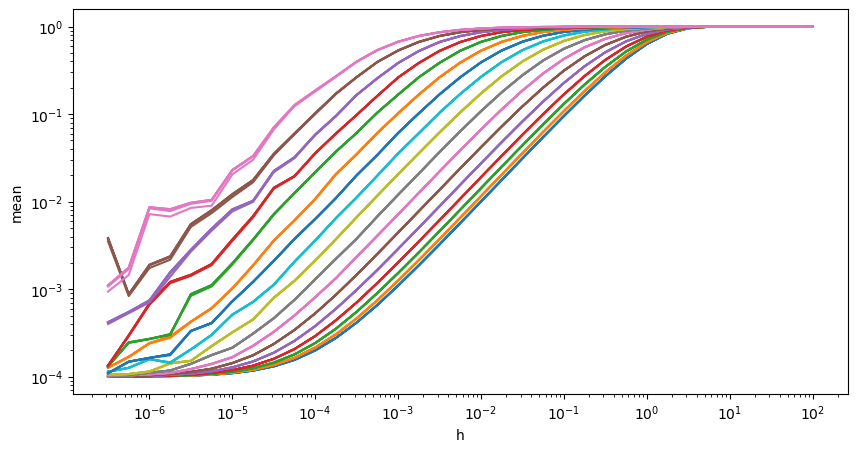

In [6]:
# plot mean as a function of h for different lambda in one plot
fig, ax = plt.subplots(1,1,figsize=(10,5))
for lambda_, group in df.groupby('lambda'):
    # get color according to id in loop
    color = ax._get_lines.get_next_color()
    for window in group['window'].unique():
        sel = group[group['window']==window]
        # sort by h
        sel = sel.sort_values(by='h')
        hvals, avals, bvals = sel['h'], sel['a'], sel['b']
        # sort hvals 
        ax.plot(hvals, avals/(avals+bvals), color=color)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('h')
ax.set_ylabel('mean')


In [8]:
# y-axis: log10(1-lambda)
xs = np.unique(df['lambda'])
print(xs)
# x-axis: h
ys = np.unique(df['h'])
np.sort(ys)
print(ys)
# for each combination (x,y) plot the mean value of the beta distribution window=1 as a color image on the left and if the relative deviation between windows is larger than 5% as a color image on the right
mean_1 = np.zeros((len(xs), len(ys)))
mean = np.zeros((len(xs), len(ys)))
std  = np.zeros((len(xs), len(ys)))
for (i,x) in tqdm(enumerate(xs), total=len(xs)):
    for (j,y) in enumerate(ys):
        sel = df[(df['h']==y) & (df['lambda']==x)]
        if len(sel)==0:
            continue
        # get a,b parameters for window=1 
        a = sel[sel['window']==1]['a'].values[0]
        b = sel[sel['window']==1]['b'].values[0]
        mean_1[i,j] = a/(a+b)
        mean_local = []
        # get number of windows
        for window in np.unique(sel['window']):
            # get a,b parameters for window
            a = sel[sel['window']==window]['a'].values[0]
            b = sel[sel['window']==window]['b'].values[0]
            mean_local.append(a/(a+b))
        std[i,j] = np.std(mean_local)
        mean[i,j] = np.mean(mean_local)

[0.         0.43765867 0.68377223 0.82217206 0.9        0.94376587
 0.96837722 0.98221721 0.99       0.99437659 0.99683772 0.99822172
 0.999      0.99943766 0.99968377 0.99982217 0.9999    ]
[3.16227766e-07 5.62341325e-07 1.00000000e-06 1.77827941e-06
 3.16227766e-06 5.62341325e-06 1.00000000e-05 1.77827941e-05
 3.16227766e-05 5.62341325e-05 1.00000000e-04 1.77827941e-04
 3.16227766e-04 5.62341325e-04 1.00000000e-03 1.77827941e-03
 3.16227766e-03 5.62341325e-03 1.00000000e-02 1.77827941e-02
 3.16227766e-02 5.62341325e-02 1.00000000e-01 1.77827941e-01
 3.16227766e-01 5.62341325e-01 1.00000000e+00 1.77827941e+00
 3.16227766e+00 5.62341325e+00 1.00000000e+01 1.77827941e+01
 3.16227766e+01 5.62341325e+01 1.00000000e+02]


  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:02<00:00,  6.48it/s]


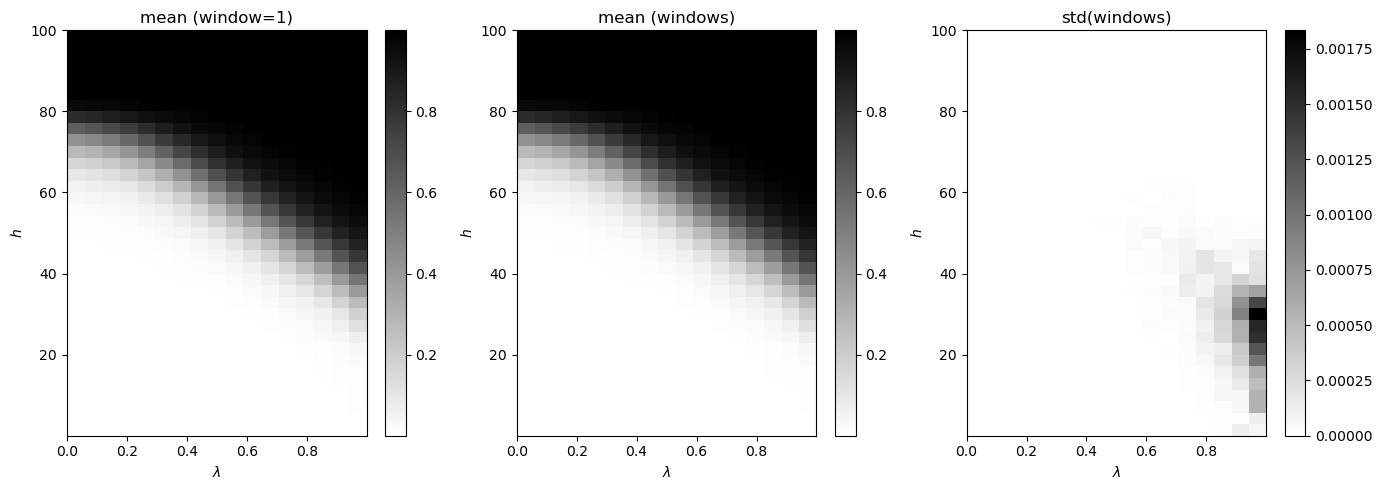

In [9]:
# color plot of mean in left plot
fig, axes = plt.subplots(1,3, figsize=(14,5))
# x,y are linear in log10 space
im = axes[0].imshow(mean_1.T, extent=[xs[0], xs[-1], ys[0], ys[-1]], cmap='gray_r', origin='lower', aspect='auto')
axes[0].set_xlabel('$\lambda$')
axes[0].set_ylabel('$h$')
axes[0].set_title('mean (window=1)')
# show colorbar
cbar = fig.colorbar(im, ax=axes[0])
# mean over windows
im = axes[1].imshow(mean.T, extent=[xs[0], xs[-1], ys[0], ys[-1]], cmap='gray_r', origin='lower', aspect='auto')
axes[1].set_xlabel('$\lambda$')
axes[1].set_ylabel('$h$')
axes[1].set_title('mean (windows)')
# show colorbar
cbar = fig.colorbar(im, ax=axes[1])
# std over windwos
im = axes[2].imshow(std.T, extent=[xs[0], xs[-1], ys[0], ys[-1]], cmap='gray_r', origin='lower', aspect='auto')
axes[2].set_xlabel('$\lambda$')
axes[2].set_ylabel('$h$')
axes[2].set_title('std(windows)')
cbar = fig.colorbar(im, ax=axes[2])
fig.tight_layout()

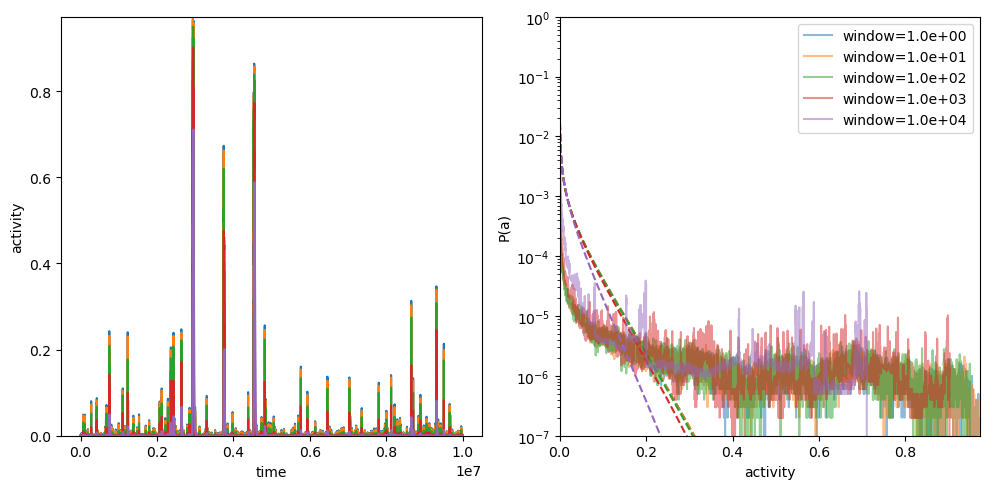

In [28]:
# show comparison for lambda and h examples
fig, axes = plt.subplots(1,2, figsize=(10,5))
range_data = [1,0]
lam = 0.9999
h = 1e-6
sel = df[(df['lambda']==lam) & (df['h']==h)]
windows = sel['window'].values
windows = np.sort(windows)

for (i,window) in enumerate(windows):
    sel_window = sel[sel['window']==window]
    # get data from hdf5 file
    if len(sel_window['raw_file'].values) > 1:
        raise ValueError('Multiple raw files found')
    raw_file = sel_window['raw_file'].values[0]
    dataset = sel_window['dataset'].values[0]
    with h5py.File(raw_file, 'r') as file:
        data = np.array(file[dataset])
        axes[0].plot(data)
        # plot distribution
        N = file.attrs['N']
        delta = 1/N
        support = np.linspace(0,1,N+1)
        pmf_data = np.histogram(data, bins=np.append(support,1+delta)-delta/2, density=False)[0]/len(data)
        ref = axes[1].plot(support, pmf_data, label=f'window={windows[i]:.1e}', alpha=0.5)
        # plot beta distribution
        a = sel_window['a'].values[0]
        b = sel_window['b'].values[0]
        loc = sel_window['loc'].values[0]
        scale = sel_window['scale'].values[0]
        pmf_beta = stats.beta.pdf(support, a,b, loc=loc, scale=scale)
        pmf_beta = pmf_beta/np.sum(pmf_beta)
        axes[1].plot(support,pmf_beta, color=ref[0].get_color(), linestyle='--')
        range_data[0] = min(range_data[0], support[np.nonzero(pmf_data)][0])
        range_data[1] = max(range_data[1], support[np.nonzero(pmf_data)][-1])
axes[0].set_xlabel('time')
axes[0].set_ylabel('activity')
axes[1].set_xlabel('activity')
axes[1].set_ylabel('P(a)')
# set xrange to range of data
axes[1].set_yscale('log')
axes[1].set_ylim([1e-7,1])
axes[1].set_xlim(range_data)
axes[0].set_ylim(range_data)
axes[1].legend()
plt.tight_layout()
plt.show()